In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from keras import Sequential
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# ignorar warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Entendendo os dados

In [2]:
# definindo o caminho para os drives
data_folder = '/Users/victorvieira/Library/Mobile Documents/com~apple~CloudDocs/Codes/animal10-1/data/raw/animal10_small'

# definindo o nome das classes com base nos drives
animal_names = sorted(os.listdir(data_folder))
animal_names

['.DS_Store',
 'butterfly',
 'cat',
 'chicken',
 'cow',
 'dogs',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [3]:
# eliminando a nasta '.DS_Store'
animal_names.remove('.DS_Store')

In [4]:
# conferindo o balanceamento dos dados
animal_sizes = [len(os.listdir(data_folder + "/" + name))for name in animal_names]

animal_sizes

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

In [5]:
# agrupando todas as imagens em uma única lista
animal_type = [os.path.join(data_folder + '/' + name) for name in animal_names]
animals = [os.path.join(name + '/' + file) for name in animal_type for file in os.listdir(name)]

# Treinando o modelo ResNet50

In [6]:
# carregando o modelo ResNet50 pré-treinado
base_model = ResNet50(include_top=False, pooling='avg', input_shape=(224,224,3), weights='imagenet')
# criando um modelo sequencial com o ResNet50
resnet = Sequential()
resnet.add(base_model)

In [7]:
# processando as imagens com ResNet50
resnet_list = []
for img in animals:
    image = load_img(img, target_size=(224,224))
    images = img_to_array(image)
    images = preprocess_input(np.expand_dims(images.copy(), axis=0))
    resnet_feature = resnet.predict(images)
    resnet_list.append(np.array(resnet_feature).flatten())

resnet_array = np.array(resnet_list)
print(f'O ResNet50 encontrou {resnet_array.shape[1]} features para cada imagem.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [8]:
print(f'O ResNet50 encontrou {resnet_array.shape[1]} features para cada imagem.')

O ResNet50 encontrou 2048 features para cada imagem.


In [9]:
# utilizando a a Análise de Componentes Principais (Principal Component Analysis - PCA) para examinar as relações entre as features
from sklearn import manifold, decomposition
pca = decomposition.PCA(n_components=0.9)
reduc_features = pca.fit_transform(resnet_array)
print(f'Após a utilização da PCA, o número de features foi condensado para {reduc_features.shape[1]}.')

Após a utilização da PCA, o número de features foi condensado para 422.


# Clusterização com o K-Means

In [10]:
# clusterização com o K-Means
kmeans = KMeans(n_clusters=10,
                init='k-means++',
                random_state=7)

In [11]:
# fazendo a predição com o modelo
pred_labels = kmeans.fit_predict(reduc_features)

In [12]:
pred_labels

array([6, 6, 9, ..., 1, 1, 1], dtype=int32)

In [13]:
# criando uma tabela com arquivos e clusters
df_results = pd.DataFrame(animals, columns=['image_file'])
df_results["cluster_label"] = pred_labels
df_results['class'] = np.where(
    df_results['image_file'].str.contains("butterfly"), "butterfly",
    (np.where(df_results['image_file'].str.contains("cat"), "cat",
    (np.where(df_results['image_file'].str.contains("chicken"), "chicken",
    (np.where(df_results['image_file'].str.contains("cow"), "cow", 
    (np.where(df_results['image_file'].str.contains("dogs"), "dogs",
    (np.where(df_results['image_file'].str.contains("elephant"), "elephant",
    (np.where(df_results['image_file'].str.contains("horse"), "horse",
    (np.where(df_results['image_file'].str.contains("sheep"), "sheep",
    (np.where(df_results['image_file'].str.contains("spider"), "spider",
    (np.where(df_results['image_file'].str.contains("squirrel"), "squirrel", 'other'))
    )))))))))))))))))

df_results.sample(20)

image_file  cluster_label  \
4446  /Users/victorvieira/Library/Mobile Documents/c...              5   
1575  /Users/victorvieira/Library/Mobile Documents/c...              2   
3141  /Users/victorvieira/Library/Mobile Documents/c...              3   
695   /Users/victorvieira/Library/Mobile Documents/c...              8   
4748  /Users/victorvieira/Library/Mobile Documents/c...              1   
2306  /Users/victorvieira/Library/Mobile Documents/c...              3   
4681  /Users/victorvieira/Library/Mobile Documents/c...              1   
3002  /Users/victorvieira/Library/Mobile Documents/c...              2   
1665  /Users/victorvieira/Library/Mobile Documents/c...              2   
1990  /Users/victorvieira/Library/Mobile Documents/c...              2   
707   /Users/victorvieira/Library/Mobile Documents/c...              8   
3981  /Users/victorvieira/Library/Mobile Documents/c...              7   
4128  /Users/victorvieira/Library/Mobile Documents/c...              6   
94    /Users/victorvieira/Library/Mobile Documents/c...              9   
357   /Users/victorvieira/Library/Mobile Documents/c...              6   
551   /Users/victorvieira/Library/Mobile Documents/c...              8   
2991  /Users/victorvieira/Library/Mobile Documents/c...              0   
1158  /Users/victorvieira/Library/Mobile Documents/c...              4   
1445  /Users/victorvieira/Library/Mobile Documents/c...              4   
153   /Users/victorvieira/Library/Mobile Documents/c...              9   

          class  
4446     spider  
1575        cow  
3141      horse  
695         cat  
4748   squirrel  
2306       dogs  
4681   squirrel  
3002      horse  
1665        cow  
1990        cow  
707         cat  
3981      sheep  
4128     spider  
94    butterfly  
357   butterfly  
551         cat  
2991   elephant  
1158    chicken  
1445    chicken  
153   butterfly

### Visualização dos Dados

In [14]:
def image_show(images, labels, cluster):
    '''
    função para plotar uma imagem e o cluster.
    '''
    index = np.where(labels == cluster)[0]
    sample_index = np.random.choice(index, 5, replace=False)
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(sample_index):
        plt.subplot(1, 5, i+1)
        image = load_img(images[idx], target_size=(256, 256))
        plt.imshow(image)
        plt.axis('off')
    plt.show()

Cluster 1:


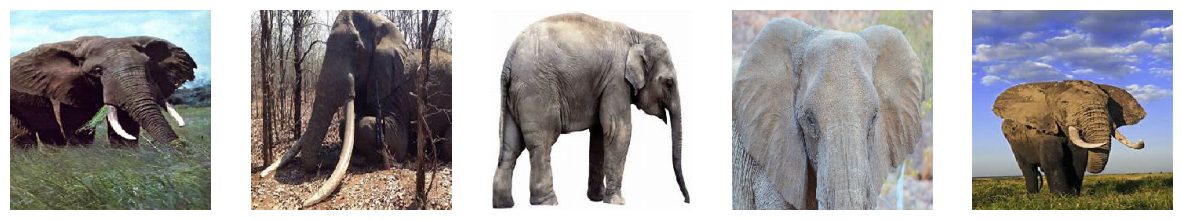

Cluster 2:


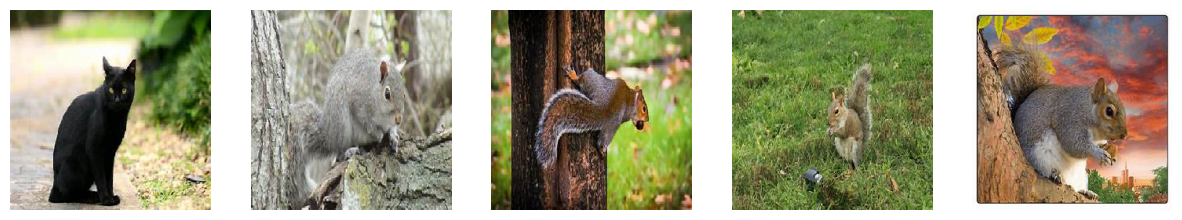

Cluster 3:


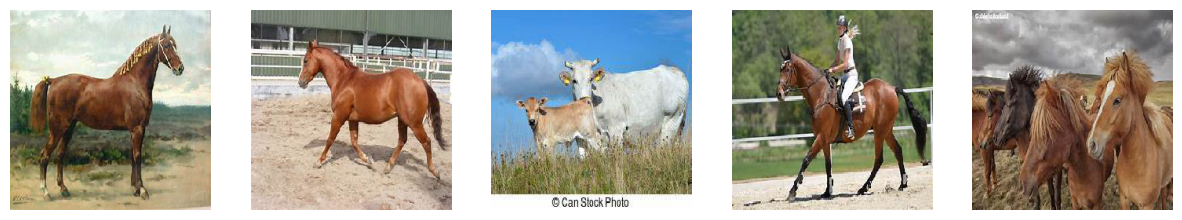

Cluster 4:


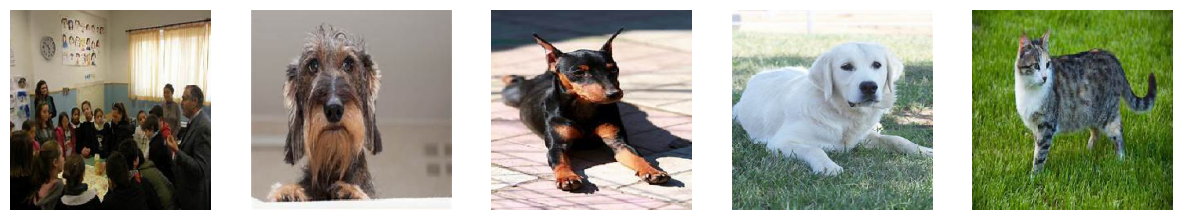

Cluster 5:


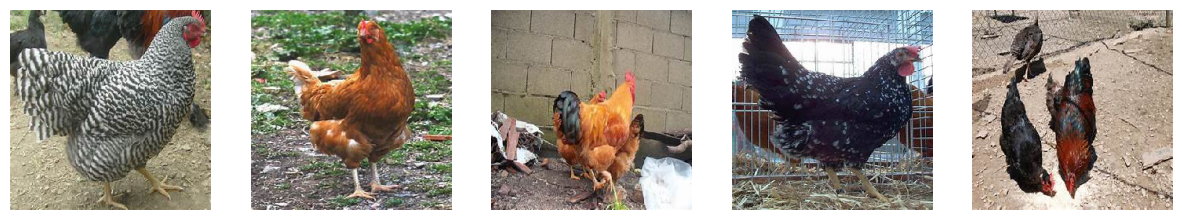

Cluster 6:


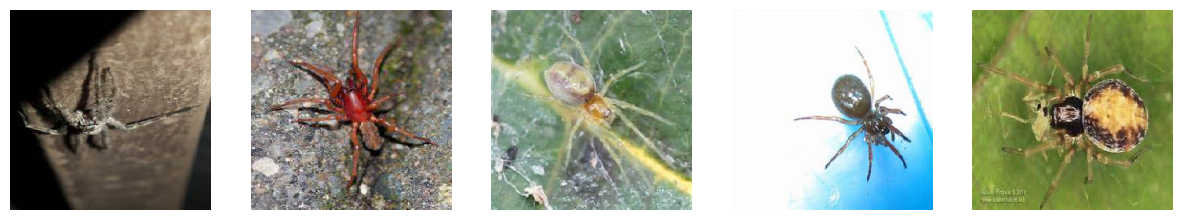

Cluster 7:


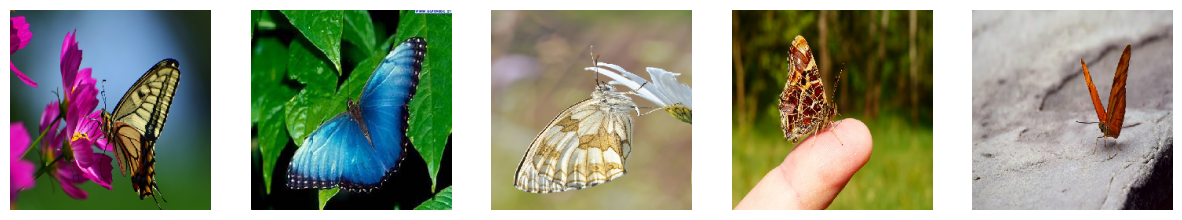

Cluster 8:


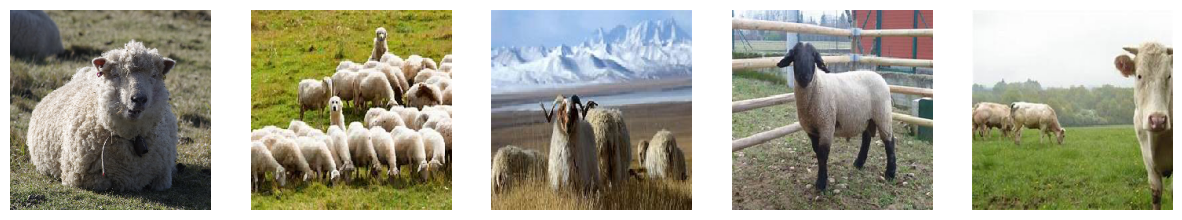

Cluster 9:


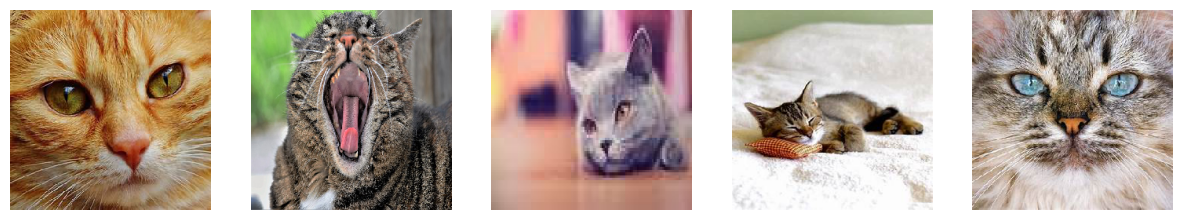

Cluster 10:


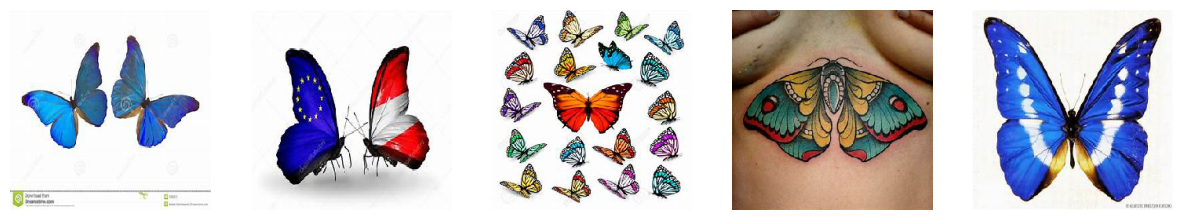

In [15]:
# chamando a função para cada cluster
for cluster in range(10):
    print(f'Cluster {cluster + 1}:')
    image_show(animals, pred_labels, cluster)

# Avaliando o modelo

In [16]:
# criando uma tabela apenas com 'cass'e 'cluster_label'
base= df_results[['cluster_label', 'class']].value_counts().reset_index()
base.columns = ['cluster_label', 'class', 'count']

In [17]:
# pivotando essa tabela
tabela = base.pivot_table(index='cluster_label',
                          columns='class',
                          values='count',
                          fill_value=0
                          ).reset_index(drop=True)

In [18]:
# determinando a classe mais presente em cada grupo
previsao = tabela.idxmax().reset_index()
previsao.columns = ['class', 'y_pred']
previsao

class  y_pred
0  butterfly       6
1        cat       8
2    chicken       4
3        cow       2
4       dogs       3
5   elephant       0
6      horse       2
7      sheep       7
8     spider       5
9   squirrel       1

In [19]:
df_results = pd.merge(df_results, previsao, how='left', on= 'class')

<Axes: xlabel='class'>

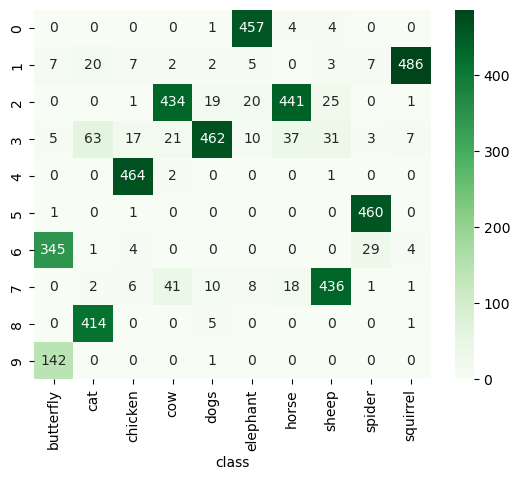

In [20]:
# plotando a tabela
sns.heatmap(tabela, annot=True, cmap='Greens', fmt='.0f')

Ao definir o número de clusters do K-Means para 10, observamos que o algorítmo teve um desempenho positivo na maioria das classes de animais. A grande excessão pode ser observada no cluster 2, onde o algoritmo agrupou 434 vacas e 441 cavalos como pertencentes de um mesmo cluster. Como consequência disso, também é possível observar a divisão das borboletas em dois grupos, de modo que 345 delas ficaram no cluster 6 e 142 no cluster 9.